In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.time import parse_time
from sunpy.time import TimeRange
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.table import Table
from astropy.io import ascii
from astropy.timeseries import aggregate_downsample, TimeSeries

In [46]:
solar25_max = Time("2024-10-01T00:00")  # from M. C. Gallego et al 2025 Res. Notes AAS 9 202
mission_start = Time("2025-09-01T00:00")
mission_end = mission_start + TimeDelta(1 * u.year)
extended_end = mission_start + TimeDelta(2 * u.year)

In [52]:
# the following file is created by get_flares.py
flares = TimeSeries.read("solar_cycle2425_flares.csv", time_column='event_starttime')
# add goes class string
flares["goes_cls"] = [gclass[0] for gclass in flares['fl_goescls']]
# add goes class number
flares['goes_clsnum'] = [float(gclass[1:]) for gclass in flares['fl_goescls']]
# add column for summing flares
flares['count'] = np.ones(len(flares), dtype=np.uint16)

In [53]:
flares

time,event_peaktime,event_endtime,fl_goescls,ar_noaanum,goes_cls,goes_clsnum,count
Time,str23,str23,str4,int64,str1,float64,uint16
2009-07-05 07:07:00.000,2009-07-05 7:13:00,2009-07-05 7:18:00,C2.7,11024,C,2.7,1
2009-07-06 16:59:00.000,2009-07-06 17:05:00,2009-07-06 17:11:00,C1.0,11024,C,1.0,1
2009-09-25 00:47:00.000,2009-09-25 1:02:00,2009-09-25 1:16:00,C2.0,11026,C,2.0,1
2009-10-25 02:10:00.000,2009-10-25 2:26:00,2009-10-25 2:37:00,C1.5,11029,C,1.5,1
2009-10-26 18:38:00.000,2009-10-26 19:06:00,2009-10-26 19:11:00,C1.2,11029,C,1.2,1
2009-10-26 22:35:00.000,2009-10-26 22:50:00,2009-10-26 22:53:00,C1.3,11029,C,1.3,1
2009-10-26 23:29:00.000,2009-10-26 23:33:00,2009-10-26 23:35:00,C1.0,11029,C,1.0,1
2009-10-27 04:49:00.000,2009-10-27 5:00:00,2009-10-27 5:10:00,C1.2,0,C,1.2,1
2009-10-27 07:05:00.000,2009-10-27 7:24:00,2009-10-27 7:30:00,C1.2,11029,C,1.2,1


Create individual flare lists for flare classes

In [54]:
keys = ["C", "M", "M5", "X"]
flares_by_class = {"M": flares[flares["goes_cls"] == "M"], 
                "C": flares[flares["goes_cls"] == "C"], 
                "X": flares[flares["goes_cls"] == "X"],
                "M5": flares[(flares["goes_cls"] == "M") * (flares["goes_clsnum"] >= 5)]}

In [55]:
flares_by_class["M5"]

time,event_peaktime,event_endtime,fl_goescls,ar_noaanum,goes_cls,goes_clsnum,count
Time,str23,str23,str4,int64,str1,float64,uint16
2010-02-07 02:20:00.000,2010-02-07 2:34:00,2010-02-07 2:39:00,M6.4,11045,M,6.4,1
2010-02-12 11:19:00.000,2010-02-12 11:26:00,2010-02-12 11:28:00,M8.3,11046,M,8.3,1
2010-11-06 15:27:00.000,2010-11-06 15:36:00,2010-11-06 15:44:00,M5.4,11121,M,5.4,1
2011-02-13 17:28:00.000,2011-02-13 17:38:00,2011-02-13 17:47:00,M6.6,11158,M,6.6,1
2011-02-18 09:55:00.000,2011-02-18 10:11:00,2011-02-18 10:15:00,M6.6,11158,M,6.6,1
2011-03-08 10:35:00.000,2011-03-08 10:44:00,2011-03-08 10:55:00,M5.3,11165,M,5.3,1
2011-07-30 02:04:00.000,2011-07-30 2:09:00,2011-07-30 2:12:00,M9.3,11261,M,9.3,1
2011-08-03 13:17:00.000,2011-08-03 13:48:00,2011-08-03 14:10:00,M6.0,11261,M,6.0,1
2011-08-04 03:41:00.000,2011-08-04 3:57:00,2011-08-04 4:04:00,M9.3,11261,M,9.3,1


Create a list of months to downsample to

In [67]:
years = range(2010, 2050)
months = range(1, 12)
month_bin_starts = []
for this_year in years:
    for this_month in months:
        month_bin_starts.append(Time(f"{this_year}-{this_month:02}-01T00:00:00"))

c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Downsample the flare lists to monthly flare counts

In [116]:
flare_count_ts = {}
for this_key in flares_by_class.keys():
    this_ts = TimeSeries(time=flares_by_class[this_key].time[:], data={'count':flares_by_class[this_key]['count']})
    flare_count_ts.update({this_key: aggregate_downsample(this_ts, time_bin_start=month_bin_starts, aggregate_func=np.sum)})
    flare_count_ts[this_key]['count'][flare_count_ts[this_key]['count'].mask] = 0  # remove masked sums

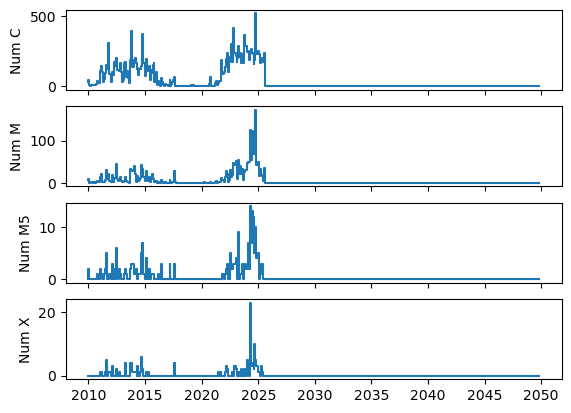

In [117]:
fig, ax = plt.subplots(len(keys), sharex=True)
for this_key, this_ax in zip(keys, ax):
    this_ax.step(flare_count_ts[this_key]["time_bin_start"].to_datetime(), flare_count_ts[this_key]["count"])
    this_ax.set_ylabel(f"Num {this_key}")

Shift in time to the next solar cycle

In [ ]:
solar_cycle_duration = TimeDelta(11.5 * u.year)
flare_count_ts_shifted = {}
for this_key in keys:
    these_flares = flares_by_class[this_key]
    new_times = these_flares.time + solar_cycle_duration
    this_ts = TimeSeries(time=new_times, data={'count':these_flares['count']})
    flare_count_ts_shifted.update({this_key: aggregate_downsample(this_ts, time_bin_start=month_bin_starts, aggregate_func=np.sum)})
    flare_count_ts_shifted[this_key]['count'][flare_count_ts_shifted[this_key]['count'].mask] = 0  # remove masked sums

c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "taiutc" yielded 9850 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "utctai" yielded 232 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "utctai" yielded 231 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "taiutc" yielded 232 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
c:\Users\sdchris1\AppData\Local\miniforge3\

c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 231 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


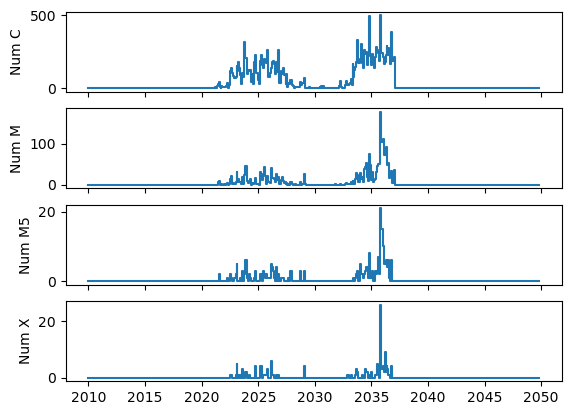

In [115]:
fig, ax = plt.subplots(len(keys), sharex=True)
for this_key, this_ax in zip(keys, ax):
    this_ax.step(flare_count_ts_shifted[this_key]["time_bin_start"].to_datetime(), flare_count_ts_shifted[this_key]["count"])
    this_ax.set_ylabel(f"Num {this_key}")

Compare the relative strengths of cycle 24 and cycle 25

In [73]:
correction_factor = {}
for this_key in keys:
    ind = flare_count_ts_shifted[this_key]['time_bin_start'] < flares.time[-1]
    total_flares_cycle24 = np.sum(flare_count_ts_shifted[this_key]['count'][ind])
    ind = flare_count_ts[this_key]['time_bin_start'] > Time("2020-01-01T00:00")
    total_flares_cycle25 = np.sum(flare_count_ts[this_key]['count'][ind])
    print(f"{this_key} {int(total_flares_cycle24)} {int(total_flares_cycle25)} {total_flares_cycle25/total_flares_cycle24:0.2f}")

C 4443 9656 2.17
M 431 1651 3.83
M5 43 144 3.35
X 30 87 2.90


In [39]:
delays = [TimeDelta(0 * u.day), TimeDelta(210 * u.day), TimeDelta(1 * u.year), TimeDelta(1.5 * u.year), TimeDelta(2 * u.year)]
[mission_start + this_delay for this_delay in delays]

[<Time object: scale='utc' format='isot' value=2025-09-01T00:00:00.000>,
 <Time object: scale='utc' format='isot' value=2026-03-30T00:00:00.000>,
 <Time object: scale='utc' format='isot' value=2026-09-01T06:00:00.000>,
 <Time object: scale='utc' format='isot' value=2027-03-02T21:00:00.000>,
 <Time object: scale='utc' format='isot' value=2027-09-01T12:00:00.000>]

In [85]:
summary_flares = Table()

for phase_e in [[mission_start, mission_end], [mission_end, extended_end]]:
    num_flares = np.zeros(len(keys))
    summary_flares['goes class'] = keys
    for i, this_key in enumerate(keys):
        ind = (flare_count_ts_shifted[this_key]['time_bin_start'] >= phase_e[0])
        ind *= (flare_count_ts_shifted[this_key]['time_bin_start'] <= phase_e[1])
        num_flares[i] = np.nansum(flare_count_ts_shifted[this_key]['count'][ind])
    summary_flares['Cycle 24 ' + str(phase_e[0].to_datetime())[0:7]] = np.nan_to_num(num_flares)

    num_flares = np.zeros(len(keys))
    # select phase E on the other side of the solar max, assumes the solar cycle is symmetric
    equivalent_phase_e = Time([solar25_max - this_t + solar25_max for this_t in phase_e]).sort()
    for i, this_key in enumerate(keys):
        ind = (flare_count_ts[this_key]['time_bin_start'] >= equivalent_phase_e[0])
        ind *= (flare_count_ts[this_key]['time_bin_start'] <= equivalent_phase_e[1])
        num_flares[i] = np.nansum(flare_count_ts[this_key]['count'][ind])
    summary_flares['Cycle 25 ' + str(phase_e[0].to_datetime())[0:7]] = np.nan_to_num(num_flares)

summary_flares

goes class,Cycle 24 2025-09,Cycle 25 2025-09,Cycle 24 2026-09,Cycle 25 2026-09
str2,float64,float64,float64,float64
C,1900.0,2919.0,1089.0,1914.0
M,188.0,368.0,89.0,154.0
M5,24.0,31.0,5.0,16.0
X,15.0,12.0,1.0,7.0


In [137]:
import io
output_buffer = io.StringIO()
summary_flares.write(output_buffer, format='latex')

# Get the LaTeX string
latex_table_string = output_buffer.getvalue()
print(latex_table_string)

\begin{table}
\begin{tabular}{ccccc}
goes class & Cycle 24 2025-09 & Cycle 25 2025-09 & Cycle 24 2026-09 & Cycle 25 2026-09 \\
C & 1900.0 & 2919.0 & 1089.0 & 1914.0 \\
M & 188.0 & 368.0 & 89.0 & 154.0 \\
M5 & 24.0 & 31.0 & 5.0 & 16.0 \\
X & 15.0 & 12.0 & 1.0 & 7.0 \\
\end{tabular}
\end{table}



c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 231 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
C:\Users\sdchris1\AppData\Local\Temp\1\ipykernel_35740\2943748293.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\sdchris1\AppData\Local\miniforge3\envs\padre_meddea\lib\site-packages\erfa\core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 231 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


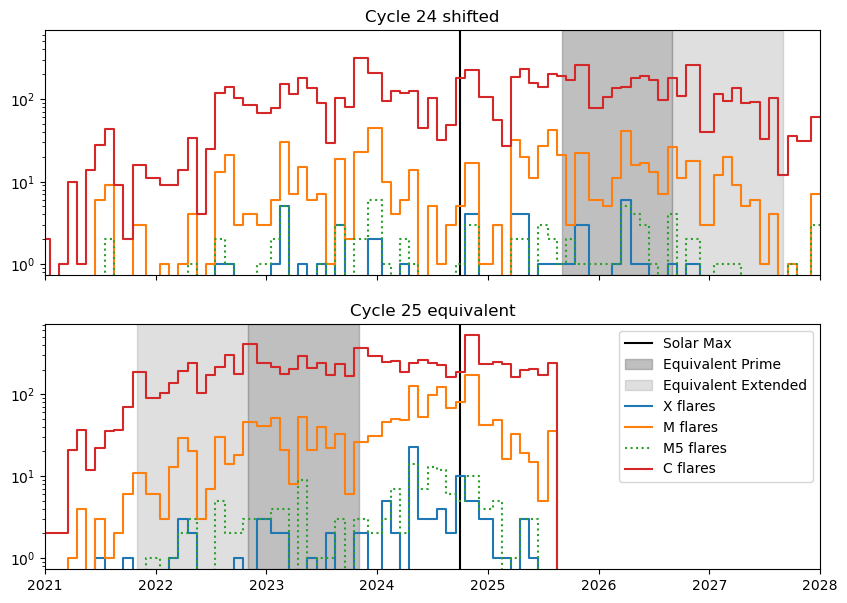

In [128]:
f, axes = plt.subplots(2, 1, sharex=True, figsize=(10, 7))
i = 0 
for this_ts, ax in zip([flare_count_ts_shifted, flare_count_ts], axes):

    ax.axvline(solar25_max.to_datetime(), color="black", label="Solar Max")

    if i == 0:
        ax.axvspan(mission_start.to_datetime(), mission_end.to_datetime(), color="grey",
                alpha=0.5,
                label="Prime"
        )
        ax.axvspan(mission_end.to_datetime(), extended_end.to_datetime(), color="grey",
                alpha=0.25,
                label="Extended"
        )

    if i == 1:
        ax.axvspan((solar25_max - mission_start + solar25_max).to_datetime(), (solar25_max - mission_end + solar25_max).to_datetime(), color="grey",
                alpha=0.5,
                label="Equivalent Prime"
        )

        ax.axvspan((solar25_max - mission_end + solar25_max).to_datetime(), (solar25_max - extended_end + solar25_max).to_datetime(), color="grey",
                alpha=0.25,
                label="Equivalent Extended"
        )
    if i == 0:
        ax.set_title('Cycle 24 shifted')
    else:
        ax.set_title('Cycle 25 equivalent')

    ax.step(
        this_ts["C"]['time_bin_start'].to_datetime(),
        this_ts["X"]["count"],
        label="X flares",
        where='mid'
    )

    ax.step(
        this_ts["C"]['time_bin_start'].to_datetime(),
        this_ts["M"]["count"],
        label="M flares",
        where='mid'
    )

    ax.step(
        this_ts["C"]['time_bin_start'].to_datetime(),
        this_ts["M5"]["count"],
        label="M5 flares",
        where='mid',
        linestyle='dotted'
    )

    ax.step(
        this_ts["C"]['time_bin_start'].to_datetime(),
        this_ts["C"]["count"],
        label="C flares",
        where='mid'
    )
    ax.set_xlim(Time("2021-01-01T00:00").to_datetime(), Time("2028-01-01T00:00").to_datetime())
    i += 1
    ax.set_yscale('log')
    plt.legend()
    plt.savefig('solar_cycle_predict.pdf')

In [130]:
(mission_start - Time('2019-12-01')).to('year')

<Quantity 5.7522245 yr>

In [134]:
def relative_diff(a, b):
    avg = np.average([a, b])
    return (b - a) / avg
relative_diff(116.4, 160.8)

np.float64(0.3203463203463203)

In [144]:
np.array([relative_diff(188, 368), relative_diff(89, 154)]).mean()

np.float64(0.591230719128401)

In [145]:
np.array([relative_diff(1900, 2919), relative_diff(1089, 1914)]).mean()

np.float64(0.4861799333681467)